In [39]:
import pandas as pd
import numpy as np
import random
from copy import copy, deepcopy
import torch
import torch.nn as nn
import math

from sktime.performance_metrics.forecasting import (mean_absolute_percentage_error,
                                                     mean_absolute_error)



import seaborn as sns

In [40]:
np.random.seed(0)
torch.manual_seed(0)

In [41]:
#creating the synthetic data
row_count = 1000
n_var = 20

if n_var<=10:
    step_val = 0.1/n_var
else:
    step_val = 0.05/n_var

start_var = np.round(np.random.rand(row_count)*10,0).tolist()
data_dct = {}

for x_var_num in range(n_var):
    data_dct[f'x{x_var_num}'] = []
data_dct[f'x{n_var-1}'] = start_var

all_cols = list(data_dct.keys())

multiply_factors = np.arange(start=1, stop=2, step=step_val)

# an implementation to produce cumulatively increasing array of values row wise
for row_num in range(row_count):
    factor_cpy = copy(multiply_factors)
    for index, x_var_num in enumerate(range(n_var-2,-1,-1)):
        # getting a window of factors as per the x_var_num
        windowed_factors = factor_cpy[index:index+3]
        last_used_factor = np.random.choice(a=windowed_factors,size=1)[0]

        calc_value = np.round(data_dct[f'x{x_var_num+1}'][row_num]*last_used_factor,2)
        
        data_dct[f'x{x_var_num}'].append(calc_value)

        factor_cpy = factor_cpy[factor_cpy>last_used_factor]

In [42]:
main_df = pd.DataFrame(data_dct)
main_df.head(3)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19
0,134.17,87.98,59.65,41.71,30.06,22.39,17.22,13.67,11.16,9.38,8.10,7.18,6.50,5.99,5.61,5.34,5.17,5.06,5.01,5.0
1,163.88,108.53,74.21,52.54,38.42,28.94,22.52,18.02,14.80,12.49,10.81,9.59,8.72,8.11,7.67,7.36,7.16,7.05,7.00,7.0
2,131.15,87.58,60.40,42.99,31.55,23.90,18.71,15.06,12.45,10.55,9.17,8.19,7.46,6.94,6.56,6.31,6.16,6.07,6.02,6.0


In [43]:
is_diff_data = False

if is_diff_data:
    main_df = pd.DataFrame(np.round(main_df[all_cols[:-1]].to_numpy()-main_df[all_cols[1:]].to_numpy(),3), columns=all_cols[:-1])
    n_var = len(main_df.columns)
    all_cols = list(main_df.columns)
    main_df.head()

In [44]:
def get_batch_indexes(batch_size, data_len, train_len):
    total_batches = train_len//batch_size

    batch_indexes = np.column_stack((np.arange(start=0,stop=data_len, step=batch_size),
               np.arange(start=0+batch_size,stop=data_len+batch_size, step=batch_size)))
    return batch_indexes[:total_batches]
    

In [45]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_emb, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_emb).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_emb, 2).float() * -(math.log(10000.0) / d_emb)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)[:pe[:, 0::2].shape[0],:pe[:, 0::2].shape[1]]
        pe[:, 1::2] = torch.cos(position * div_term)[:pe[:, 1::2].shape[0],:pe[:, 1::2].shape[1]]

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(2)]
    
class PositionalEmbeddingV2(nn.Module):
    def __init__(self, d_emb, seq_len):
        super(PositionalEmbeddingV2, self).__init__()
        # Compute the positional encodings once in log space.
        POS_EMB = torch.zeros(d_emb, seq_len).float()
        POS_EMB.requires_grad=False

        POS = torch.arange(0, seq_len).repeat(d_emb,1)
        DIV = 10**(4*torch.arange(0, d_emb).reshape(-1,1).repeat(1,seq_len)*2/d_emb)

        POS_EMB[0::2, :] = torch.sin(POS/DIV)[0::2, :]
        POS_EMB[1::2, :] = torch.cos(POS/DIV)[1::2, :]
        self.register_buffer('POS_EMB', POS_EMB)

    def forward(self):
        return self.POS_EMB

    
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_emb):
        super(TokenEmbedding, self).__init__()
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_emb, 
                                    kernel_size=3, padding=1)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='leaky_relu')

    def forward(self, x):
        # x = self.tokenConv(x.permute(0, 2, 1)).transpose(1,2)
        x = self.tokenConv(x)
        return x
    

class Attention(nn.Module):
    def __init__(self, d_k,d_v,d_emb ) -> None:
        super(Attention, self).__init__()
        self.d_emb = d_emb
        self.W_query = nn.Parameter(torch.rand(d_k,d_emb))
        self.W_keys = nn.Parameter(torch.rand(d_k,d_emb))
        self.W_value = nn.Parameter(torch.rand(d_v,d_emb))

    def context_mat(self,query, keys):
        # scaled dot product of queries and keys
        Q_K = query.matmul(keys.permute(0,2,1))/np.sqrt(self.d_emb)
        # row-wise softmax
        sfmax_Q_K = torch.softmax(Q_K, dim=1)

        return sfmax_Q_K

    def forward(self,embed):

        query = embed.matmul(self.W_query.T) 
        keys = embed.matmul(self.W_keys.T)
        values = embed.matmul(self.W_value.T)
        
        sfmax_Q_K = self.context_mat(query=query, keys=keys)

        att_out = sfmax_Q_K.matmul(values).contiguous()

        return att_out, sfmax_Q_K
    

class AttentionForecastModel(nn.Module):
    def __init__(self, d_k,d_v,d_emb, batch_size, seq_len, out_seq_len, c_in=1) -> None:
        super(AttentionForecastModel, self).__init__()
        self.dim_emb = d_emb
        self.batch_size = batch_size
        self.seq_len=seq_len
        self.c_in = c_in
        self.out_seq_len = out_seq_len

        self.pos_emb = PositionalEmbeddingV2(seq_len=seq_len,d_emb=d_emb)
        self.token_emb = TokenEmbedding(c_in=c_in, d_emb=d_emb)
        self.attention = Attention(d_emb=d_emb,d_k=d_k, d_v=d_v)
        self.linear_layer = nn.Linear(in_features=seq_len*d_v, out_features=out_seq_len)

        self.sfmax_Q_K = None

    def embed_output(self,input):
        input_tensor = torch.tensor(input.reshape((self.batch_size,self.c_in,self.seq_len)), 
                                    dtype=torch.float32)
        token_emb_out = self.token_emb(input_tensor)
        pos_emb_out = self.pos_emb()

        # changing dimensions while keeping the batch size dim the same
        embed_tensor = token_emb_out+pos_emb_out
        return embed_tensor.permute(0,2,1)


    def forward(self, input):
        embed_tensor = self.embed_output(input)
        attn_out, sfmax_Q_K=self.attention(embed_tensor)
        self.sfmax_Q_K = sfmax_Q_K
        final_output = self.linear_layer(attn_out.reshape((self.batch_size,-1)))

        return final_output
        

In [46]:
# # FOR DEBUGGING
# EPOCHS = 50
# OUT_VAR = 5
# BATCH_SIZE = 10
# feat_cols = all_cols[OUT_VAR:-1]
# tgt_cols = all_cols[:OUT_VAR]

# train_len = int(row_count*0.8)
# batch_indexes = get_batch_indexes(batch_size=BATCH_SIZE, data_len=row_count, train_len=train_len)
# st_index,end_index = batch_indexes[0]

# Model = AttentionForecastModel(d_k=4, 
#                                d_v=3, 
#                                d_emb=5, 
#                                batch_size=BATCH_SIZE,
#                                seq_len=len(feat_cols), 
#                                out_seq_len=len(tgt_cols))
# batch_data = main_df.iloc[st_index:end_index]
# feat_data = batch_data[feat_cols].to_numpy()
# # tgt_data = torch.tensor(batch_data[tgt_cols].to_numpy(), dtype=torch.float32)

# embed = Model.embed_output(feat_data)
# attn_out, sfmax_Q_K = Model.attention(embed)
# print(attn_out.shape)


# input_tnsr = torch.tensor(feat_data.reshape((Model.batch_size,Model.c_in,Model.seq_len)), 
#                                     dtype=torch.float32)
# print(input_tnsr.shape)
# Model.token_emb(input_tnsr).shape


# tst_conv_layer = nn.Conv1d(in_channels=3, out_channels=1, 
#                                     kernel_size=3, padding=1)

# tst_conv_layer(attn_out.permute(0,2,1)).shape

# Model(feat_data)

torch.Size([10, 14, 3])


In [47]:
EPOCHS = 50
OUT_VAR = 5
BATCH_SIZE = 10
feat_cols = all_cols[OUT_VAR:-1]
tgt_cols = all_cols[:OUT_VAR]

train_len = int(row_count*0.8)
batch_indexes = get_batch_indexes(batch_size=BATCH_SIZE, data_len=row_count, train_len=train_len)

Model = AttentionForecastModel(d_k=4, 
                               d_v=3, 
                               d_emb=5, 
                               batch_size=BATCH_SIZE,
                               seq_len=len(feat_cols), 
                               out_seq_len=len(tgt_cols))
optimizer = torch.optim.Adam(Model.parameters(), lr = 0.01)

for epoch in range(EPOCHS):
    epch_trn_cost = 0
    for st_index, end_index in batch_indexes:
        batch_data = main_df.iloc[st_index:end_index]
        feat_data = batch_data[feat_cols].to_numpy()
        tgt_data = torch.tensor(batch_data[tgt_cols].to_numpy(), dtype=torch.float32)

        pred_out = Model(feat_data)
        cost = nn.functional.huber_loss(pred_out,tgt_data)
        epch_trn_cost+=(float(cost.detach())/BATCH_SIZE)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

    if epoch%10==0:
        print('train cost:',epch_trn_cost )


    

train cost: 88.97503935098644
train cost: 17.081099903583528
train cost: 11.454840859770778
train cost: 6.718141293525697
train cost: 4.523226238042117


In [48]:
test_data = main_df.iloc[800:]

test_feat_data = test_data[feat_cols].to_numpy()
test_tgt_data = test_data[tgt_cols].to_numpy()

Model.batch_size= row_count-train_len
test_pred = Model(test_feat_data).detach().numpy()

test_pred_data = pd.DataFrame(np.round(test_pred,2))
test_pred_data.columns = [f'pred_x{i}' for i in range(OUT_VAR)]

In [49]:
combined_test_data =pd.concat([test_data.reset_index(drop=True),test_pred_data], axis=1)

In [50]:
metrics_df = {'pred_col':[],'SMAPE':[]}
for i in range(OUT_VAR):
    pred_col = f'pred_x{i}'
    smape= mean_absolute_percentage_error(y_pred=combined_test_data[pred_col],
                               y_true=combined_test_data[f'x{i}'],
                               symmetric=True)
    metrics_df['pred_col'].append(pred_col)
    metrics_df['SMAPE'].append(smape)

metrics_df = pd.DataFrame(metrics_df)
metrics_df

,pred_col,SMAPE
0,pred_x0,0.084342
1,pred_x1,0.082287
2,pred_x2,0.078588
3,pred_x3,0.084798
4,pred_x4,0.084006


In [51]:
combined_test_data

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x15,x16,x17,x18,x19,pred_x0,pred_x1,pred_x2,pred_x3,pred_x4
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.490000,0.260000,0.300000,0.260000,0.380000
1,146.02,96.70,66.12,46.81,34.23,25.88,20.14,16.11,13.26,11.19,...,6.44,6.22,6.08,6.02,6.0,148.289993,97.459999,67.349998,46.480000,33.900002
2,109.97,72.35,49.22,34.54,25.03,18.68,14.34,11.31,9.18,7.67,...,4.28,4.15,4.07,4.02,4.0,111.330002,72.910004,49.900002,34.189999,24.700001
3,104.29,68.84,46.99,33.15,24.11,18.06,13.97,11.13,9.12,7.68,...,4.32,4.17,4.08,4.02,4.0,105.559998,69.269997,47.630001,32.740002,23.770000
4,197.74,130.52,89.09,62.74,45.71,34.43,26.69,21.35,17.57,14.89,...,8.55,8.28,8.12,8.04,8.0,196.369995,129.059998,89.250000,61.660000,44.990002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,25.34,16.78,11.51,8.15,5.95,4.47,3.46,2.76,2.26,1.90,...,1.07,1.03,1.01,1.00,1.0,25.969999,17.160000,11.720000,8.300000,6.020000
196,133.07,86.83,58.57,40.89,29.52,22.03,16.95,13.45,10.98,9.23,...,5.28,5.13,5.04,5.00,5.0,128.399994,84.239998,57.939999,39.840000,28.930000
197,263.14,171.15,115.06,80.04,57.58,42.73,32.68,25.78,20.92,17.43,...,9.55,9.25,9.07,9.00,9.0,254.699997,166.690002,114.080002,78.320000,56.509998
198,52.24,34.31,23.30,16.38,11.87,8.86,6.83,5.43,4.44,3.73,...,2.13,2.06,2.02,2.00,2.0,51.750000,33.980000,23.280001,16.090000,11.740000


In [52]:
test_attention_out = Model.sfmax_Q_K

In [53]:
len(feat_cols)

14

<Axes: >

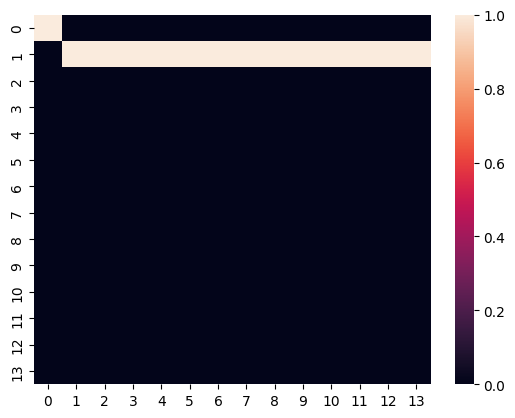

In [54]:
sns.heatmap(test_attention_out[9].detach().numpy())

In [55]:
# batch_size = 10
# input = main_df[all_cols].iloc[:batch_size].to_numpy().reshape((batch_size,1,7))

# tok_emb = TokenEmbedding(c_in=1, d_emb=5)
# output_tokn = tok_emb(torch.tensor(input, dtype=torch.float32))

# pos_emb = PositionalEmbedding(d_emb=5)

# output_pos = pos_emb(torch.tensor(input))

# output_emb = output_tokn.permute(0,2,1)+output_pos
